In [1]:
    # Importing required Library

In [2]:
import sklearn
import PIL
from matplotlib import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage import transform, color
from PIL import Image 
import numpy as np
from os import listdir
from os.path import isfile, join
import os

In [3]:
  # Loading Data of Cells (Infected and Not Infected)

In [4]:
sample_images_positive = []
i=0
for filename in listdir('C:/Users/daruw/SCM DATA/cell_images/Parasitized'):
    if i < 10:
        img = plt.imread('C:/Users/daruw/SCM DATA/cell_images/Parasitized/' + filename)
        sample_images_positive.append(img)
        i+=1

In [5]:
sample_images_negative = []
i=0
for filename in listdir('C:/Users/daruw/SCM DATA/cell_images/Uninfected/'):
    if i < 10:
        img = plt.imread('C:/Users/daruw/SCM DATA/cell_images/Uninfected/' + filename)
        sample_images_negative.append(img)
        i+=1

In [6]:
#EDA Analysis

<Figure size 432x288 with 0 Axes>

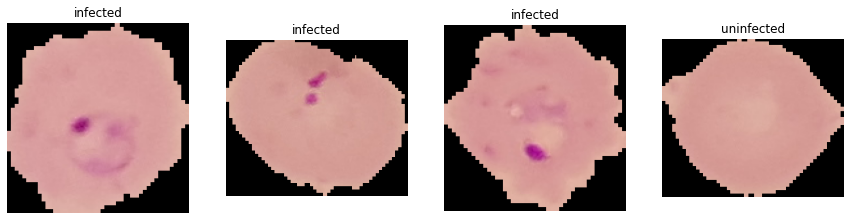

In [7]:
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(15,15))
ax1 = axes[0]
ax1.imshow(sample_images_positive[0], cmap='Greys_r')
ax1.set_title('infected')
ax1.axis('off')
ax2 = axes[1]
ax2.imshow(sample_images_positive[5], cmap='Greys_r')
ax2.set_title('infected')
ax2.axis('off')
ax3 = axes[2]
ax3.imshow(sample_images_positive[9], cmap='Greys_r')
ax3.set_title('infected')
ax3.axis('off')
ax4 = axes[3]
ax4.imshow(sample_images_negative[0], cmap='Greys_r')
ax4.set_title('uninfected')
ax4.axis('off');

In [8]:
# Infected photos have deeper stains of different colours. 
#These can come in a wide variety of shapes, sizes, and colours. 
#The stain morphology appears to be of secondary importance.
#The border between the samples and the black background is where the photos' peak contrast is visible. 
#This could be detrimental to the algorithm.

In [9]:
#The following factors suggest switching to a grayscale colour scheme.
#By switching the colour scheme to grayscale, 
#the generalisation is boosted because the colour agent may take on a different colour in different data samples.
#One colour channel datasets are simpler to manage and require less computation.

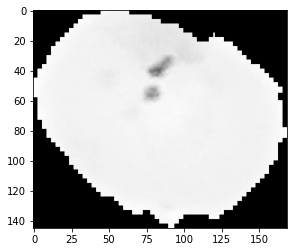

In [10]:
image_grayscale = color.rgb2gray(sample_images_positive[5])
plt.imshow(image_grayscale, cmap='Greys_r')

In [11]:
#The darkest portions of the image are the stains left by the infected cells, 
#Which may make it simpler for the algorithm to distinguish between samples that are infected and those that are not.
#In order to maintain the photographs' resolution,
#the border between the sample and the background is no longer the function's dominant pattern.

In [12]:
def padding(image, size):
    desired_size = size
    old_size = image.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = image.resize(new_size, Image.ANTIALIAS)
    new_im = Image.new('RGB',(desired_size, desired_size))
    new_im.paste(image, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    return new_im

In [13]:
# Adjusting image background

In [14]:
def brighten(image):
    max_ = np.max(image)
    image[image==0.0] = max_
    return image

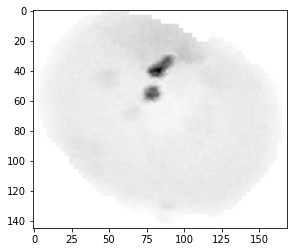

In [15]:
img = sample_images_positive[5]
img = np.array(img)
img = color.rgb2gray(img)
img = brighten(img)
plt.imshow(img, cmap='Greys_r');

In [16]:
X_positive_bright = []
for filename in listdir('C:/Users/daruw/SCM DATA/cell_images/Parasitized/'):
    if 'Thumbs.db' not in filename:
        img = Image.open('C:/Users/daruw/SCM DATA/cell_images/Parasitized/' + filename)
        img = padding(img, 220)
        img = np.array(img)
        img = color.rgb2gray(img)
        img = brighten(img.reshape(220*220))
        img = transform.resize(img.reshape(220,220), (100,100))
        X_positive_bright.append(img)
X_positive_bright = np.array(X_positive_bright)

In [17]:
X_negative_bright = []
for filename in listdir('C:/Users/daruw/SCM DATA/cell_images/Uninfected/'):
    if 'Thumbs.db' not in filename:
        img = Image.open('C:/Users/daruw/SCM DATA/cell_images/Uninfected/' + filename)
        img = padding(img, 220)
        img = np.array(img)
        img = color.rgb2gray(img)
        img = brighten(img.reshape(220*220))
        img = transform.resize(img.reshape(220,220), (100,100))
        X_negative_bright.append(img)
X_negative_bright = np.array(X_negative_bright)

In [18]:
X_positive_bright = X_positive_bright.reshape(13779, 100*100)
X_negative_bright = X_negative_bright.reshape(13779, 100*100)

In [19]:
X_positive_bright.min(), X_positive_bright.max(), X_negative_bright.min(), X_negative_bright.max()

(0.08069954011243408,
 0.9148203921568627,
 0.05867339546138914,
 0.9469815686274506)

In [20]:
from sklearn.decomposition import PCA
X_full = np.row_stack((X_positive_bright, X_negative_bright))
pca_full_variance = PCA(n_components = 0.95) 
pca_full_variance.fit(X_full) 
pca_full_variance.components_.shape

(96, 10000)

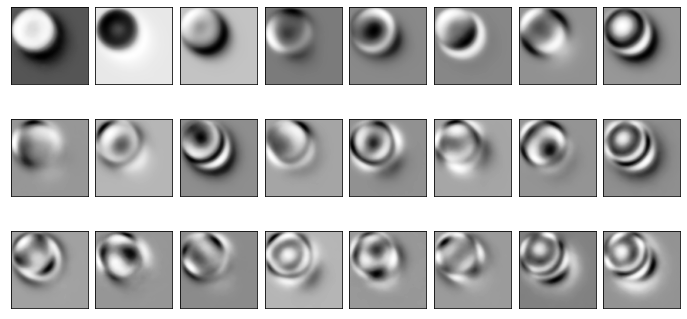

In [21]:
fig, axes = plt.subplots(3, 8, figsize=(12, 6),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca_full_variance.components_[i].reshape(100, 100), cmap='Greys_r')

In [22]:
X_reduced = pca_full_variance.transform(X_full)
X_reduced.shape

(27558, 96)

In [23]:
#SVM
#The approach is particularly effective for dichotomous classification 
#since it is resistant to overfitting even with a large number of features 
#can effectively handle non-linearity when using the rbf kernel.


In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [25]:
y_positive = np.ones(X_positive_bright.shape[0])
y_negative = np.zeros(X_negative_bright.shape[0])
y = np.hstack((y_positive, y_negative))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, stratify=y, train_size=0.7)

In [27]:
model_svc = SVC(C=70782, gamma=0.000977)
model_svc.fit(X_train, y_train)

SVC(C=70782, gamma=0.000977)

In [28]:
pred = model_svc.predict(X_test)

In [29]:
accuracy_score(y_test, pred)

0.8963473633284954

C:\Users\daruw\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


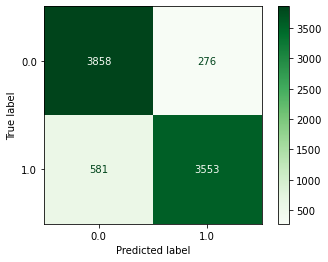

In [31]:
plot_confusion_matrix(model_svc, X_test, y_test,
                     cmap=plt.cm.Greens)
plt.show();

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, pred)

In [40]:
with open('svm_results.npy', 'wb') as f:
    np.save(f, cm)